# Equity Implied Forward & Volatility Surface
------------------
> **Idriss Afra**

This project aims to construct the implied dividend yield curve and volatility surface from European equity option prices.

## Model Description
The implied volatility surface plays a crucial role in derivative pricing and risk management. Constructing this surface from listed option prices usually involves two main steps. First, since forward prices are not directly available in the market, a forward curve must be derived in a way that aligns with the observed option prices. Second, once the forward curve is determined, an implied volatility skews must be calibrated to match the observed prices of the options.

### Implied Forward
For a given expiry, call-put parity implies that the call and put should have the same price at the ATM-forward strike -- the strike equal to the forward price.
<br> To estimate the forward from discrete listed strikes, we interpolate the call and put price curves across strikes and take the intersection point where the two curves are equal. We use `PchipInterpolator`, a shape-preserving, piecewise-cubic interpolator, because it tends to avoid spurious oscillations and better preserves the expected monotonic shape of option prices across strikes.

### Implied Borrow Rate
Stocks and equity indices incur a cost of carry, which can be estimated using their associated repo rates. However, this cost is typically small, especially over the long term, and it is often slightly negative or near zero for indices due to their relatively low risk profile.
<br> In this project, the cost of carry will be derived from market option prices and will be implicitly reflected in the implied dividend part.

### Implied Dividend
European companies typically pay cash dividends on a quarterly, semi-annual, or annual basis, with a noticeable seasonality in their dividend patterns. As a result, practitioners often forecast future dividend payment dates by assuming the same payment days and months as in previous years. A new "seasoned" dividend curve is then bootstrapped as follows:

Under the Non-Arbitrage assumption : $F_{T^{Exp}_n} = S_t × e^{r (T^{Exp}_n-t)} - ∑_{k ∈ [1,n]}d_k × e^{r(T^{Exp}_n-T_k)}$ 

Therefore :  $d_n = e^{-r\left(T^{Exp}_n-T_n\right)} × \left( S_t × e^{r \left(T^{Exp}_n-t\right)} - ∑_{k ∈ [1,n-1]}d_k × e^{r\left(T^{Exp}_n-T_k\right)} - F_{T^{Exp}_n} \right)$ 

And finally : $d_n = S_t × e^{r \left(T_n-t\right)} - ∑_{k ∈ [1,n-1]}d_k × e^{r\left(T_n-T_k\right)} - F_{T^{Exp}_n} × e^{-r(T^{Exp}_n-T_n)}$ 


Where  :
* $S_t$ the spot price at $t$
* $r$ the zero-coupon rate
* $\left(F_{T^{Exp}_n}\right)_n$ are the implied forwards at the market option expiries $\left(T^{Exp}_n\right)_n$
* $(d_k)_k$ are the expected cash dividends paid at the projected Ex-dividend dates $(T_k)_k$

On the other hand, practitioners typically assume continuous dividend yield curves for the indices. The most straightforward method to construct these curves is by assuming a piecewise constant curve between the market option expiries:

Under the Non-Arbitrage assumption : $F_{T^{Exp}_n} = S_t × e^{r \left(T^{Exp}_n-t\right) - ∑_{k ∈ [1,n]}q_k × \left(T^{Exp}_{k} - T^{Exp}_{k-1} \right)}$ 

Therefore : $q_n = ln\left( S_t × e^{r \left(T^{Exp}_n-t\right) - ∑_{k ∈ [1,n-1]}q_k × \left(T^{Exp}_{k} - T^{Exp}_{k-1} \right)} / F_{T^{Exp}_n}\right) / \left( T^{Exp}_n - T^{Exp}_{n-1}\right)$

Where  : $(q_k)_k$ are the piecewise constant instantaneous forward dividend yields between $\left( T^{Exp}_k - T^{Exp}_{k-1}\right)$

Cash and yield dividends can then be extrapolated with a flat yield after the last market option expiry.


### Implied Volatility
Given the implied forwards at the listed maturities, volatilities can be numerically calibrated from out-the-money listed call and put options, which are generally more liquid than in-the-money options. The entire volatility surface is then constructed by using interpolation and extrapolation methods across the strike and expiry axes.

---
## Application : CAC40 Listed Index Options

Let's derive the forward and dividend curves, along with the volatility surface, for the CAC40 French index. To achieve this, we use the CAC40 European market option quotes retrieved as of February 12, 2025, from the EURONEXT website :

In [1]:
# Required Libraries
import datetime
import pandas as pd
from scipy.interpolate import PchipInterpolator
import warnings

as_of_date = datetime.date(2025, 2, 12)
print("Analysis Date : ", as_of_date)
print("-----------------------------------------------")
eq_underlying = "CAC40"
S0 = 8042.19
print(f"{eq_underlying} Close Price : ", S0)
print("-----------------------------------------------")
option_data = pd.read_csv(f"MarketData/{eq_underlying}_MarketOptions_{as_of_date.strftime('%d%m%Y')}.csv")
print(f"{eq_underlying} Market Options :")
print(option_data)
print("-----------------------------------------------")
rate_underlying = "EURIBOR6M"
print(f"{rate_underlying} Zero-Coupon Rate Curve :")
rates_data = pd.read_csv(f"MarketData/{rate_underlying}_ZCRates_{as_of_date.strftime('%d%m%Y')}.csv")
print(rates_data)

# ZC Rate Function: PCHIP Interpolation & Extrapolation
if len(rates_data) < 2:
    raise ValueError("rates_data must have at least 2 points for interpolation.")
if (rates_data['ZCRate'] < -0.1).any() or (rates_data['ZCRate'] > 0.5).any():
    warnings.warn("Some zero-coupon rates are outside typical range [-10%, 50%]. Check input data.")
if rates_data['Expiry'].is_monotonic_increasing:
    zc_rate = PchipInterpolator(rates_data['Expiry'], rates_data['ZCRate'], extrapolate=True)
else:
    raise ValueError("rates_data['Expiry'] is not monotonically increasing. Sort the data.")

Analysis Date :  2025-02-12
-----------------------------------------------
CAC40 Close Price :  8042.19
-----------------------------------------------
CAC40 Market Options :
            Expiry   Strike    Call      Put
0    February-2025   7925.0  151.83    27.92
1    February-2025   7950.0  132.52    33.59
2    February-2025   7975.0  114.13    40.18
3    February-2025   8000.0   96.79    47.82
4    February-2025   8025.0   81.15    57.17
..             ...      ...     ...      ...
137  December-2029   8000.0  977.10  1115.35
138  December-2029   8400.0  808.07  1308.91
139  December-2029   8800.0  665.26  1528.71
140  December-2029   9600.0  450.36  2039.01
141  December-2029  10400.0  312.97  2626.83

[142 rows x 4 columns]
-----------------------------------------------
EURIBOR6M Zero-Coupon Rate Curve :
    Expiry  ZCRate
0     0.02  0.0268
1     0.25  0.0264
2     0.50  0.0251
3     0.75  0.0239
4     1.00  0.0233
5     1.25  0.0228
6     1.50  0.0226
7     1.75  0.0225
8     

First, let's convert the expiry dates. According to EURONEXT documentation, these dates correspond to the third Friday of each month :

In [2]:
def third_friday(month, year):
    """
    Returns the third friday of month/year.
    """
    result = datetime.date(year, month, 15)
    nb = result.weekday()
    if nb != 4:
        # Replace just the day (of month)
        result = result.replace(day=(15 + (4 - nb) % 7))
    return result

# Computes the exact option expiry (Third friday of months) :
months_nb = {"January" : 1, "February" : 2, "March" : 3, "April" : 4, "May" : 5, "June" : 6, "July" : 7, 
               "August" : 8 , "September" : 9, "October" : 10, "November" : 11, "December" : 12}
for i, row in option_data.iterrows():
    month, year = row['Expiry'].split("-")
    month, year = months_nb[month], int(year)
    option_data.at[i,'Expiry'] = (third_friday(month, year) - as_of_date).days / 365
print(f"{eq_underlying} Market Options :")
option_data

CAC40 Market Options :


,Expiry,Strike,Call,Put
0,0.024658,7925.0,151.83,27.92
1,0.024658,7950.0,132.52,33.59
2,0.024658,7975.0,114.13,40.18
3,0.024658,8000.0,96.79,47.82
4,0.024658,8025.0,81.15,57.17
...,...,...,...,...
137,4.857534,8000.0,977.10,1115.35
138,4.857534,8400.0,808.07,1308.91
139,4.857534,8800.0,665.26,1528.71
140,4.857534,9600.0,450.36,2039.01


Next, let's gather the market data and store it in global dictionaries :

In [3]:
# Required Libraries
import numpy as np

def collect_data(option_data):
    """
    Collects options market data and store it in dictionaries.
    """
    # Sanity checks
    if option_data is None or option_data.empty:
        raise ValueError("option_data cannot be None or empty.")
    if not all(col in option_data.columns for col in ['Expiry', 'Strike', 'Call', 'Put']):
        raise ValueError("option_data must contain columns: 'Expiry', 'Strike', 'Call', 'Put'")
    if (option_data['Call'] < 0).any() or (option_data['Put'] < 0).any():
        raise ValueError("Option prices must be non-negative.")
    if (option_data['Strike'] <= 0).any():
        raise ValueError("Strikes must be positive.")
    # Data collection
    strikes, call_prices, put_prices = dict(), dict(), dict()
    expiries = np.sort(np.unique(option_data['Expiry']))
    for exp in expiries :
        df = option_data[option_data['Expiry'] == exp]
        df = df.sort_values(by=['Strike'])
        strikes[exp], call_prices[exp], put_prices[exp] = list(df['Strike']), list(df['Call']), list(df['Put'])
    return {"Strikes" : strikes, "Call Prices" : call_prices, "Put Prices" : put_prices}    

# Collected Data
data = collect_data(option_data)
market_strikes = data["Strikes"]
listed_expiries = list(market_strikes.keys())
call_prices = data["Call Prices"]
put_prices = data["Put Prices"]  

Let's implement a proof of concept for deriving the forward using the method explained earlier. We will select the very last listed expiry and demonstrate the intersection of the fitted call and put price curves, which corresponds to the at-the-money strike, and thus the implied forward :

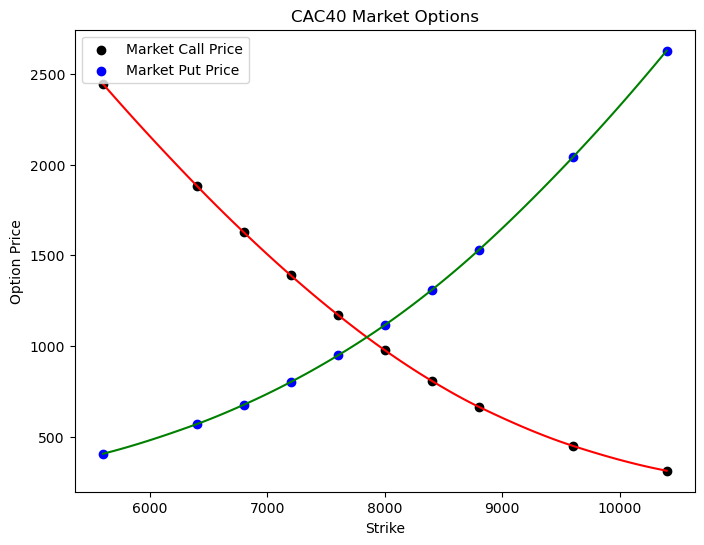

In [4]:
# Required Libraries
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

expiry = listed_expiries[-1]

plt.title(eq_underlying + " Market Options")
plt.ylabel("Option Price")
plt.xlabel("Strike")
plt.scatter(market_strikes[expiry], call_prices[expiry], label="Market Call Price", color="black")
plt.scatter(market_strikes[expiry], put_prices[expiry], label="Market Put Price", color="blue")
x_axis = np.linspace(list(market_strikes[expiry])[0], list(market_strikes[expiry])[-1], 101, endpoint=True)
call_price_func = PchipInterpolator(market_strikes[expiry], call_prices[expiry], extrapolate=True)
plt.plot(x_axis, call_price_func(x_axis), color="red")
put_price_func = PchipInterpolator(market_strikes[expiry], put_prices[expiry], extrapolate=True)
plt.plot(x_axis, put_price_func(x_axis), color="green")
plt.legend(loc="upper left")
plt.show()

The implied forward up to this last listed maturity seems to be around 7800-7900...

Let's apply this approach to all the listed expiries :


Expiry 0.0247 : The implied forward is 8048.9952
Expiry 0.1014 : The implied forward is 8066.5172
Expiry 0.1781 : The implied forward is 8079.0009
Expiry 0.3507 : The implied forward is 7943.4909
Expiry 0.6000 : The implied forward is 7987.5023
Expiry 0.8493 : The implied forward is 8003.0037
Expiry 1.0986 : The implied forward is 8039.0938
Expiry 1.3479 : The implied forward is 7930.9368
Expiry 1.5973 : The implied forward is 7943.9465
Expiry 1.8466 : The implied forward is 7969.9493
Expiry 2.8438 : The implied forward is 7897.7210
Expiry 3.8411 : The implied forward is 7872.7641
Expiry 4.8575 : The implied forward is 7847.3265



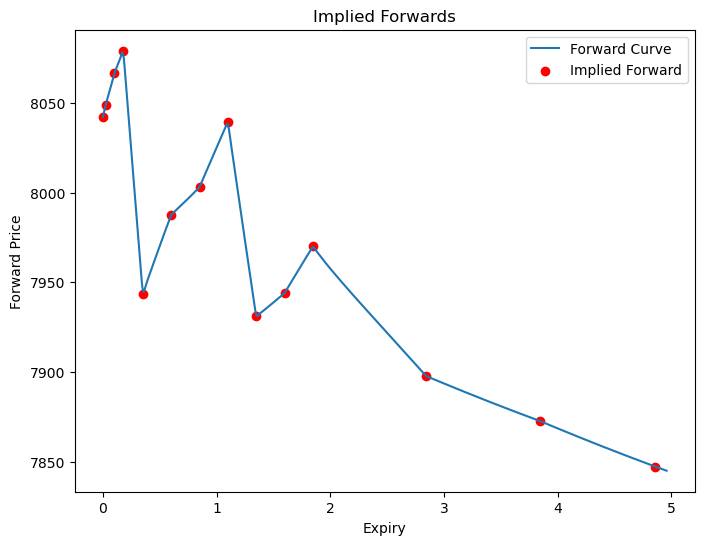


And its corresponding "Borrow + Dividend" curve :


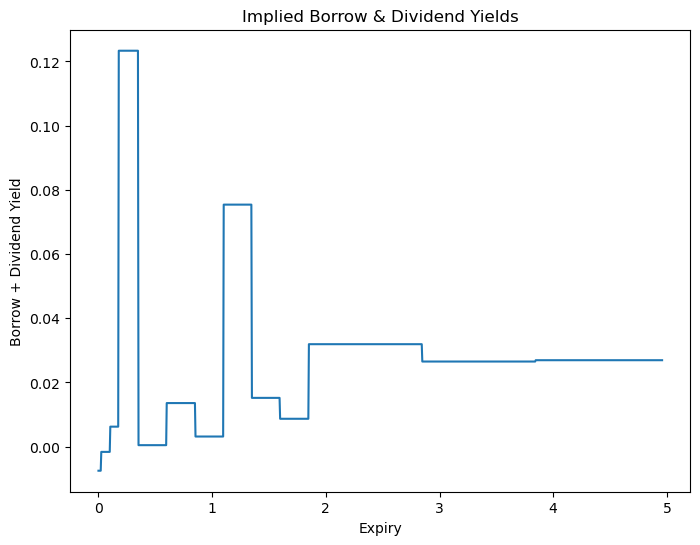

In [5]:
# Required Libraries
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

class ForwardCurve:
    """
    The implied forward curve class.
    """
    def __init__(self, S0, zc_rate, listed_expiries, market_strikes, call_prices, put_prices):
        """
        Init method : It sets the implied forwards, borrow + dividend yields, and plot them both.
        """
        # Sanity checks
        if S0 <= 0: raise ValueError("S0 (spot price) must be positive.")
        if zc_rate is None or not callable(zc_rate):
            raise ValueError("zc_rate must be a callable function.")
        if not listed_expiries or len(listed_expiries) == 0:
            raise ValueError("listed_expiries cannot be empty.")
        if not all(exp > 0 for exp in listed_expiries):
            raise ValueError("All expiries must be positive.")
        if len(market_strikes) != len(call_prices) or len(market_strikes) != len(put_prices):
            raise ValueError("market_strikes, call_prices, and put_prices must have the same length.")
        if not all(exp in market_strikes for exp in listed_expiries):
            raise ValueError("All listed_expiries must exist in market_strikes dictionary.")
        if any(len(market_strikes[exp]) == 0 for exp in listed_expiries):
            raise ValueError("No empty strike lists allowed.")
        # Attributes
        self.S0 = S0
        self.zc_rate = zc_rate
        self.listed_expiries = listed_expiries
        self.strikes = market_strikes
        self.call_prices = call_prices
        self.put_prices = put_prices
        self.set_implied_forwards()
        self.set_implied_borrow_and_divs()
        self.plot_implied_data()
    
    def implied_forward(self, exp, n_max=250, eps=1e-6):
        """
        returns the implied forward using the Call / Put parity.
        A bisection algorithm is applied to a decreasing function : K => Call(K) - Put(K).
        """
        # Sanity checks
        if exp not in self.listed_expiries: raise ValueError(f"Expiry {exp} not found in listed_expiries.")
        # Option price functions (PCHIP Interpolation & Extrapolation)
        call_price_func = PchipInterpolator(self.strikes[exp], self.call_prices[exp], extrapolate=True)
        put_price_func = PchipInterpolator(self.strikes[exp], self.put_prices[exp], extrapolate=True)
        # ATM Strike (Forward) Solver
        K_min = self.strikes[exp][0]
        K_max = self.strikes[exp][-1]
        f_min = call_price_func(K_min) - put_price_func(K_min)
        f_max = call_price_func(K_max) - put_price_func(K_max)
        # Expand bracket if needed
        if f_min * f_max > 0:
            for _ in range(10):
                K_min *= 0.95 
                K_max *= 1.05
                f_min = call_price_func(K_min) - put_price_func(K_min)
                f_max = call_price_func(K_max) - put_price_func(K_max)
                if f_min * f_max <= 0:
                    break
            if f_min * f_max > 0:
                raise ValueError(f"Call-Put diff does not change sign on [{K_min}, {K_max}]: f_min={f_min:.4f}, f_max={f_max:.4f}.")
        # Bisection algorithm
        n = 1
        while n <= n_max:
            atm_strike = (K_min + K_max) / 2
            obj_func = call_price_func(atm_strike) - put_price_func(atm_strike)
            if (obj_func == 0) or (K_max - K_min <= eps):
                return atm_strike
            if obj_func < 0:
                K_max = atm_strike
            else:
                K_min = atm_strike
            n += 1
        raise ValueError("The algorithm failed to converge.")

    def set_implied_forwards(self, n_max=250, eps=1e-6):
        """
        Setter method : Stores the market implied forwards in a dictionary.
        """
        implied_forwards = dict()
        for exp in self.listed_expiries: implied_forwards[exp] = self.implied_forward(exp, n_max, eps)
        self.implied_forwards = implied_forwards

    def set_implied_borrow_and_divs(self):
        """
        Setter method of implied borrow plus dividends, assuming they are piecewise constant between the market expiries.
        """
        implied_borrow_and_divs = dict()
        cumul = 0.
        exp_prev = 0
        for exp in self.listed_expiries:
            dt = exp - exp_prev
            if dt <= 0: raise ValueError("The given listed expiries are not strictly increasing. Check input data.")
            implied_borrow_and_divs[exp] = np.log(self.S0 * np.exp(self.zc_rate(exp) * exp - \
                                         cumul) / self.implied_forwards[exp]) / (exp - exp_prev)
            cumul += implied_borrow_and_divs[exp] * (exp - exp_prev)
            exp_prev = exp
        # Implied Borrow + Dividend Yields
        self.implied_borrow_and_divs = implied_borrow_and_divs
        # Borrow + Dividend function : Piece-Wise Interpolation / Flat Extrapolation
        times = [0] + self.listed_expiries
        values = list(implied_borrow_and_divs.values()) + [list(implied_borrow_and_divs.values())[-1]]
        self.borrow_div_func = interp1d(times, values, kind='previous', bounds_error=False, fill_value=(values[0], values[-1]))
        
    def calc_forward(self, exp):
        """
        Computes the forward up to exp, given the borrow_div_func method.
        """
        if exp < 0: raise ValueError("Expiry (exp) must be non-negative.")
        if exp == 0: return self.S0
        expiries = [0] + self.listed_expiries + [exp]
        expiries = sorted(list(set(expiries)))
        expiries = expiries[:expiries.index(exp) + 1]
        cumul = 0
        for i in range(len(expiries) - 1):
            cumul += (expiries[i + 1] - expiries[i]) * self.borrow_div_func(expiries[i])
        return self.S0 * np.exp(self.zc_rate(exp) * exp - cumul)

    def fwd_curve(self, apply_smoothness=True, dt= 1e-4, n_interv=101, order=3):
        """
        Computes the forward curve function, using the calc_forward method.
        A smoothness is applied if apply_smoothness is True.
        """
        if not apply_smoothness : 
            return (lambda exps : [self.calc_forward(exp) for exp in exps])
        grid_t = list(np.linspace(0, self.listed_expiries[-1], int(1/dt) + 1, endpoint=True)) +  self.listed_expiries
        grid_t = sorted(list(set(grid_t)))
        calc_fwd_func = lambda exps : [self.calc_forward(exp) for exp in exps]
        smooth_fwds = savgol_filter(calc_fwd_func(grid_t), n_interv, order)
        return PchipInterpolator(grid_t, smooth_fwds, extrapolate=True)
    
    def plot_implied_data(self, n_interv=1000):
        """
        Implied data plotter.
        """
        print()
        for exp in self.listed_expiries:
            print(f"Expiry {exp:.4f} : The implied forward is {self.implied_forwards[exp]:.4f}")
        print()
        plt.title("Implied Forwards")
        plt.ylabel("Forward Price")
        plt.xlabel("Expiry")
        x_axis = np.linspace(0, self.listed_expiries[-1] + 0.1, n_interv)
        fwd_curve = self.fwd_curve()
        plt.plot(x_axis, fwd_curve(x_axis), label="Forward Curve")
        plt.scatter([0] + self.listed_expiries, [self.S0] + list(self.implied_forwards.values()), color="red", \
                    label="Implied Forward")
        plt.legend(loc="upper right")
        plt.show()
        print()
        print("And its corresponding \"Borrow + Dividend\" curve :")
        plt.title("Implied Borrow & Dividend Yields")
        plt.ylabel("Borrow + Dividend Yield")
        plt.xlabel("Expiry")
        plt.plot(x_axis, self.borrow_div_func(x_axis))
        plt.show()
    
forward_curve = ForwardCurve(S0, zc_rate, listed_expiries, market_strikes, call_prices, put_prices)

The curve starts with a negative implied borrow yield on the first maturities, consistent with particularly cheap short-term financing for CAC40 exposure. When the underlying is treated as liquid, high-quality collateral, financing can trade “special,” so the implied borrow/financing term behaves like a benefit yield and can pull the front-end carry below zero. The spikes around April–June are instead dividend-driven: this is the main CAC40 dividend season, so a large share of expected cash dividends falls into those expiry windows, pushing the implied dividend + borrow yield sharply higher.

We're now ready to construct the implied volatility surface:


Implied vol surface at T = 0.0247
K:    7925.00  7950.00  7975.00  8000.00  8025.00  8050.00  8075.00  8100.00  8125.00  8150.00  8200.00
IV:    14.79%   14.49%   14.18%   13.85%   13.61%   13.37%   13.17%   13.01%   12.89%   12.75%   12.58%

Implied vol surface at T = 0.1014
K:    7800.00  7850.00  7900.00  7950.00  8000.00  8050.00  8100.00  8150.00  8200.00  8250.00  8300.00
IV:    15.84%   15.41%   15.01%   14.61%   14.27%   13.95%   13.67%   13.43%   13.22%   13.04%   12.88%

Implied vol surface at T = 0.1781
K:    7800.00  7850.00  7900.00  7950.00  8000.00  8050.00  8100.00  8150.00  8200.00  8300.00  8400.00
IV:    15.67%   15.32%   14.99%   14.71%   14.38%   14.11%   13.86%   13.63%   13.42%   13.03%   12.73%

Implied vol surface at T = 0.3507
K:    7800.00  7850.00  7900.00  7950.00  8000.00  8050.00  8100.00  8150.00  8200.00  8300.00  8400.00
IV:    15.00%   14.76%   14.52%   14.30%   14.08%   13.86%   13.68%   13.52%   13.36%   13.07%   12.83%

Implied vol surface at T = 

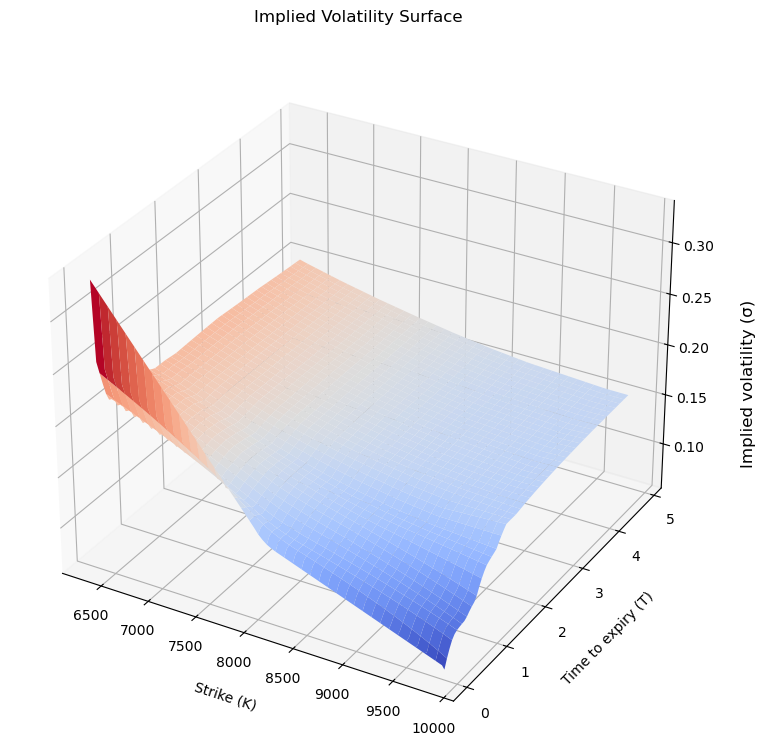

In [6]:
# Required Libraries
from scipy.stats import norm
from scipy import optimize
from matplotlib import cm

class BlackScholesModel:
    """
    The Black-Scholes model class.
    """
    def __init__(self, zc_rate, forward_curve):
        # Sanity checks
        if zc_rate is None or not callable(zc_rate):
            raise ValueError("zc_rate must be a callable function.")
        if forward_curve is None or not isinstance(forward_curve, ForwardCurve):
            raise ValueError("forward_curve must be an object of the ForwardCurve class.")
        # Attributes
        self.zc_rate = zc_rate
        self.forward_price = forward_curve.calc_forward

    def bs_price(self, exp, strike, vol, isCall=True) :
        """
        The European vanilla option Black price.
        """
        # Sanity checks
        if exp < 0: raise ValueError("Expiry (exp) must be non-negative.")
        if strike <= 0: raise ValueError("Strike must be positive.")
        if vol < 0: raise ValueError("Volatility must be non-negative.")
        if not isinstance(isCall, (bool, np.bool_)):
            raise TypeError("isCall must be a boolean.")
        # Black-Scholes formula
        r = self.zc_rate(exp)
        df = np.exp(-r * exp)
        forward = self.forward_price(exp)
        v2T = vol**2 * exp
        phi = 1 if isCall else  -1
        if v2T == 0:
            # Intrinsic value
            return df * max(0, phi * (forward - strike))
        d1 = (np.log(forward / strike) + v2T / 2) / v2T**0.5
        d2 = d1 - v2T**0.5
        return df * phi * (forward * norm.cdf(phi * d1) - strike * norm.cdf(phi * d2))
 
    def bs_vega(self, exp, strike, vol) :
        """
        The Black vega greek. 
        The derivative of the option value with respect to the volatility of the underlying asset.
        """
        # Sanity checks
        if exp < 0: raise ValueError("Expiry (exp) must be non-negative.")
        if strike <= 0: raise ValueError("Strike must be positive.")
        if vol < 0: raise ValueError("Volatility must be non-negative.")
        # Black-Scholes vega formula
        r = self.zc_rate(exp)
        df = np.exp(-r * exp)
        forward = self.forward_price(exp)
        v2T = vol**2 * exp
        if v2T == 0: return 0.
        d2 = (np.log(forward / strike) - v2T / 2) / v2T**0.5
        return df * strike * norm.pdf(d2) * exp**0.5

class ImpliedVolatilitySurface:
    """
    The implied volatility surface class.
    """
    def __init__(self, forward_curve, bs_model):
        """
        Init method : Takes the forward curve and the Black model in input.
        """
        # Sanity checks
        if forward_curve is None or not isinstance(forward_curve, ForwardCurve):
            raise ValueError("forward_curve must be an object of the ForwardCurve class.")
        if bs_model is None or not isinstance(bs_model, BlackScholesModel):
            raise ValueError("bs_model must be an object of the BlackScholesModel class.")
        # Attributes
        self.forward_price = forward_curve.calc_forward
        self.bs_model = bs_model
    
    def get_implied_vol(self, exp, strike, target_price, isCall=True, init_guess=0.5, max_iter=250, tolerance=1e-06, vol_floor=0.0001):
        """
        Volatility Solver : The Newton-Raphson algorithm.
        """
        # Sanity checks
        if exp <= 0: raise ValueError("Expiry (exp) must be positive.")
        if strike <= 0: raise ValueError("Strike must be positive.")
        if target_price < 0: raise ValueError("Target price must be non-negative.")
        if not isinstance(isCall, (bool, np.bool_)):
            raise TypeError("isCall must be a boolean.")
        if not isinstance(init_guess, (float, np.number)):
            raise TypeError("init_guess must be numeric.")
        if not isinstance(max_iter, int) or max_iter <= 0:
            raise ValueError("max_iter must be a positive integer.")
        if not isinstance(tolerance, (float, np.number)) or tolerance <= 0:
            raise ValueError("tolerance must be a positive number.")
        if not isinstance(vol_floor, (float, np.number)) or vol_floor < 0:
            raise ValueError("vol_floor must be non-negative.")
        # Newton-Raphson algorithm
        f = lambda vol : self.bs_model.bs_price(exp, strike, vol, isCall) - target_price
        f_deriv = lambda vol : self.bs_model.bs_vega(exp, strike, vol)
        try:
            implied_vol = optimize.newton(f, init_guess, f_deriv, maxiter=max_iter, tol=tolerance)
            if implied_vol <= vol_floor:
                print(f"\n /!\ Warning : The NR algorithm failed to imply a volatility for Strike {strike} at expiry {round(exp, 4)}\n")
                return vol_floor
            return implied_vol
        except:
            print(f"\n /!\ Warning : The NR algorithm failed to imply a volatility for Strike {strike} at expiry {round(exp, 4)}\n")
            return vol_floor
        
    def set_implied_vol_surface(self, market_strikes, otm_options, vol_floor=0.0001):
        """
        Returns a dictionary of Black implied volatilities, using nr_implied_vol.
        """
        # Sanity checks
        if not market_strikes or len(market_strikes) == 0:
            raise ValueError("market_strikes cannot be empty.")
        if not otm_options or len(otm_options) == 0:
            raise ValueError("otm_options cannot be empty.")
        # Implied vol surface construction
        self.strikes = market_strikes.copy()
        self.expiries = list(otm_options.keys())
        implied_vols = dict()
        for exp in self.expiries:
            strikes_exp = self.strikes[exp]
            forward_exp = self.forward_price(exp)
            implied_vols_exp = []
            filtered_strikes = []
            for i in range(len(strikes_exp)):
                isCall = (strikes_exp[i] > forward_exp)
                implied_vol = self.get_implied_vol(exp, strikes_exp[i], otm_options[exp][i], isCall, vol_floor=vol_floor)                
                # Failed calibrations are ignored in the vol surface construction
                if implied_vol >= vol_floor:
                    implied_vols_exp.append(implied_vol)
                    filtered_strikes.append(strikes_exp[i])
            if filtered_strikes != []:
                implied_vols[exp] = implied_vols_exp
                self.strikes[exp] = filtered_strikes
        self.expiries = list(self.strikes.keys())
        self.implied_vols = implied_vols

    def get_vol(self, exp, strike, min_moneyness=0.6, max_moneyness=1.4, vol_floor=0.0001):
        """
        Interpolate / Extrapolate the Black implied vol.
        Strike : linear Vol interpolation within [min_moneyness, max_moneyness] - Flat Vol extrapolation.
        Expiry : linear V2T interpolation within [min_moneyness, max_moneyness] - Flat Vol extrapolation.
        """
        # Sanity checks
        if exp <= 0: raise ValueError("Expiry (exp) must be positive.")
        if strike <= 0: raise ValueError("Strike must be positive.")
        # Check surface is initialized
        if not hasattr(self, 'implied_vols') or not self.implied_vols:
            raise RuntimeError("Implied volatility surface not initialized. Call set_implied_vol_surface first.")
        if not hasattr(self, 'expiries') or not self.expiries:
            raise RuntimeError("No expiries available in the surface.")
        if min_moneyness >= max_moneyness:
            raise ValueError(f"min_moneyness must be < max_moneyness.")
        # Interpolation / Extrapolation
        strike = min(max_moneyness * self.forward_price(exp), max(min_moneyness * self.forward_price(exp), strike))
        if (exp <= self.expiries[0]) or (exp >= self.expiries[-1]) or (exp in self.expiries):
            exp = min(self.expiries[-1], max(self.expiries[0], exp))
            return max(interp1d(self.strikes[exp], self.implied_vols[exp], kind='linear', fill_value="extrapolate")(strike), vol_floor)
        else:
            v2T_strike = [interp1d(self.strikes[T], np.array(self.implied_vols[T])**2 * T, kind='linear', \
                      fill_value="extrapolate")(strike) for T in self.expiries]
            return  max(np.sqrt(interp1d(self.expiries, v2T_strike, kind='linear', fill_value="extrapolate")(exp) / exp), vol_floor)
        
    def plot_implied_vol_surface(self, n_interv=81):
        """
        Implied volatility surface plotter.
        """
        # Sanity checks
        if not isinstance(n_interv, int) or n_interv < 10:
            raise ValueError("n_interv must be an integer >= 10.")
        if not hasattr(self, 'implied_vols') or not self.implied_vols:
            raise RuntimeError("No implied volatilities to plot. Call set_implied_vol_surface first.")
        if len(self.expiries) < 2:
            raise ValueError("At least 2 expiries required for surface plotting.")
        for exp in self.expiries:
            if len(self.strikes[exp]) < 2:
                raise ValueError(f"At least 2 strikes required for expiry {exp}.")
        # Print the implied vol surface table
        for T in sorted(self.implied_vols):
            ks = self.strikes[T]
            vols = self.implied_vols[T]
            print(f"\nImplied vol surface at T = {T:.4f}")
            print("K:   " + " ".join(f"{k:>8.2f}" for k in ks))
            vols_pct = [f"{100*v:.2f}%" for v in vols]
            print("IV:  " + " ".join(f"{v:>8}" for v in vols_pct))
        print()
        # Surface plotting
        K_min = 0.8 * max([min(self.strikes[exp]) for exp in self.expiries]) 
        K_max = 1.2 * min([max(self.strikes[exp]) for exp in self.expiries]) 
        K = np.linspace(K_min, K_max, n_interv, endpoint=True)
        T = np.linspace(self.expiries[0], self.expiries[-1], n_interv, endpoint=True)
        K, T = np.meshgrid(K, T)
        vols = np.zeros(shape=K.shape)
        for t in range(vols.shape[0]):
            for k in range(vols.shape[1]):
                vols[t, k] =  self.get_vol(T[t][k], K[t][k])
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(projection='3d')
        surf = ax.plot_surface(K, T, vols, cmap=cm.coolwarm, linewidth=0, antialiased=True)
        ax.set_xlabel("Strike (K)", labelpad=10)
        ax.set_ylabel("Time to expiry (T)", labelpad=10)
        # Workaround to ensure the display of the zlabel 
        ax.set_zlabel("")
        ax.text2D(
            1.05, 0.52, "Implied volatility (σ)",
            transform=ax.transAxes,
            rotation=90,
            va="center", ha="left",
            fontsize=12,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.8)
        )
        ax.set_title("Implied Volatility Surface", pad=20)
        fig.subplots_adjust(left=0.02, right=0.88, bottom=0.05, top=0.92)
        # Show the plot
        plt.show()

# Option Data Collector
def collect_otm_options(listed_expiries, market_strikes, call_prices, put_prices, implied_forwards):
    """
    Filters the listed options and collect the OTM ones.
    """
    # Sanity checks
    if not implied_forwards or len(implied_forwards) == 0:
        raise ValueError("implied_forwards cannot be empty.")
    # OTM options collection
    otm_options = dict()
    for exp in listed_expiries:
        strikes_exp = market_strikes[exp]
        calls_exp = call_prices[exp]
        puts_exp = put_prices[exp]
        forward_exp = implied_forwards[exp]
        otm_options_exp = []
        for i in range(len(strikes_exp)):
            otm_options_exp.append(puts_exp[i] if strikes_exp[i] <= forward_exp else calls_exp[i])
        otm_options[exp] = otm_options_exp
    return otm_options

# Application
otm_options = collect_otm_options(listed_expiries, market_strikes, call_prices, put_prices, forward_curve.implied_forwards)
bs_model = BlackScholesModel(zc_rate, forward_curve)
implied_vol_surface = ImpliedVolatilitySurface(forward_curve, bs_model)
implied_vol_surface.set_implied_vol_surface(market_strikes, otm_options)
plt.rcParams["figure.figsize"] = (11,8)
implied_vol_surface.plot_implied_vol_surface()

The CAC40 surface shows the usual equity-index downside skew: short-dated implied vols are much higher for low strikes than for high strikes, reflecting the pricing of downside tail risk and crash protection in out-of-the-money puts. As maturity increases, this skew typically softens and the surface flattens because longer-dated options are less dominated by near-term jump/event risk and are more anchored to long-run variance expectations. Lower liquidity in long maturities can also make the observed surface appear smoother across strikes.